<a href="https://colab.research.google.com/github/nour-houda-melkii/Machine-Learning-Project/blob/Deployment/ML_avanc%C3%A9e.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Crisp-DM by **DataVerse**| prediction des nombres des vélos loués par heure

In [44]:
# --- Base ---
!pip install numpy pandas matplotlib seaborn scikit-learn joblib

# --- ONNX ---
!pip install onnx onnxruntime skl2onnx

# --- Modèles ML avancés ---
!pip install xgboost lightgbm

# --- Prophet (séries temporelles) ---
!pip install prophet holidays

# --- Streamlit + ngrok ---
!pip install streamlit pyngrok

In [45]:
"""cellule pour les importations des bibliothèques"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


***Business understandig***

bo1: prévoir les heures de forte affluence pour mieux adapter l'offre aux besoins  

bo2: identifier les periodes creuses afin d'optimiser la redistribustion ou la maintenance

bo3:Evaluer les tendances saisonnières  

bo4:Analyser l’impact de la météo

bo5:Différencier le comportement des utilisateurs

bo6:Anticiper la demande future par heure



  
DSO1 : Construire un modèle prédictif capable d’identifier les heures avec un cnt élevé , en utilisant les variables temporelles (hr, weekday, workingday) et contextuelles (season, weathersit).


DSO2 : Détecter les intervalles horaires avec une faible demande (cnt bas) en exploitant des analyses statistiques (moyenne, médiane, seuils) et visualisations temporelles.


DSO3 : Analyser l’évolution de la demande (cnt) en fonction de la variable season afin de mettre en évidence les variations entre printemps, été, automne et hiver.


DSO4 : Étudier la corrélation entre la demande (cnt) et les variables météo (weathersit, temp, atemp, hum, windspeed) pour quantifier leur influence sur les locations.


DSO5 : Comparer les patterns d’utilisation entre casual et registered selon les dimensions temporelles (heure, jour, saison) et les conditions météo.



DSO6 :Prédire cnt  à une heure donnée, en intégrant les variables temporelles, météo et contextuelles.


***Data understandig***

In [46]:
df=pd.read_csv('datahour.csv')
print(df.shape)
df.head()

(17484, 17)


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,2011-01-01,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0
1,2.0,2011-01-01,1.0,0.0,1.0,1.0,0.0,6.0,NaN,1.0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0
2,3.0,2011-01-01,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0
3,4.0,2011-01-01,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0
4,5.0,2011-01-01,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0


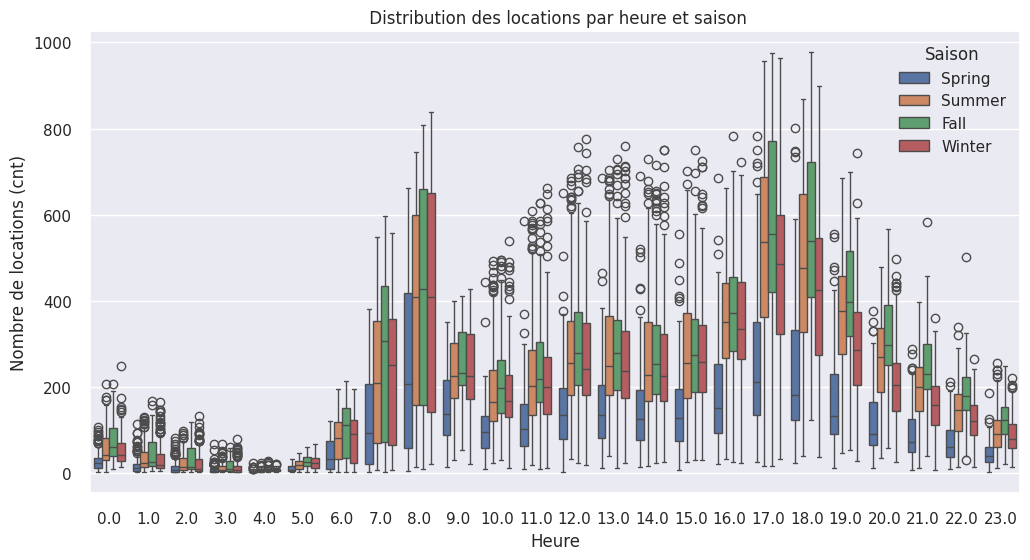

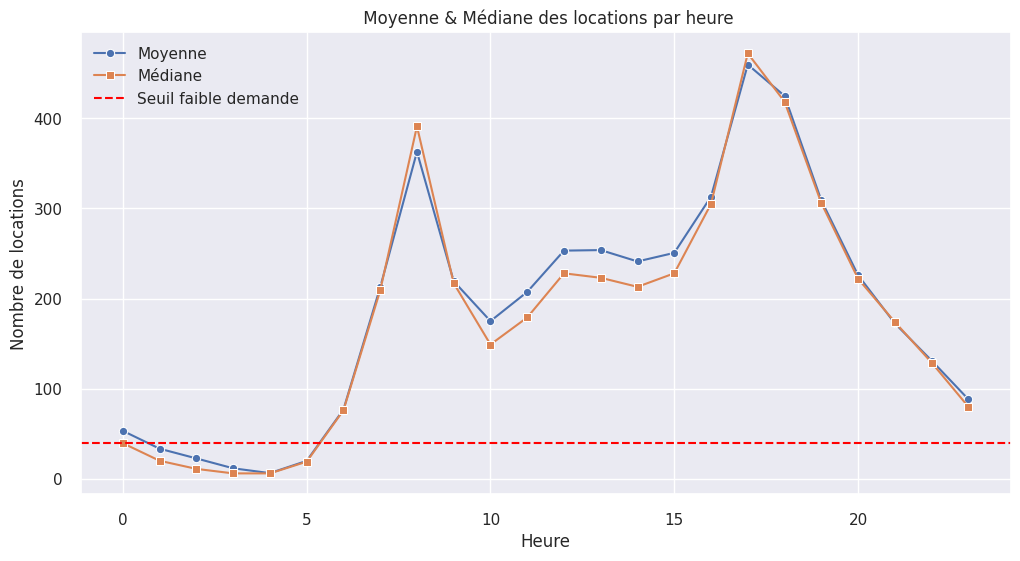

/tmp/ipython-input-2221169167.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=season_stats, x="season", y="cnt", palette="coolwarm")


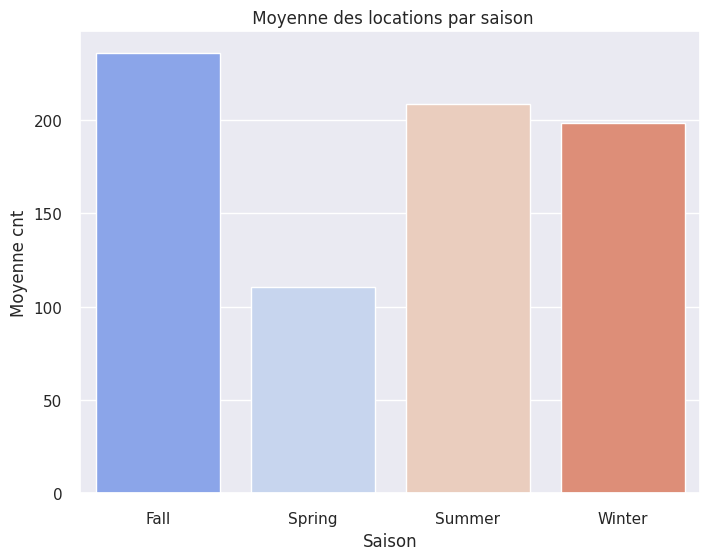

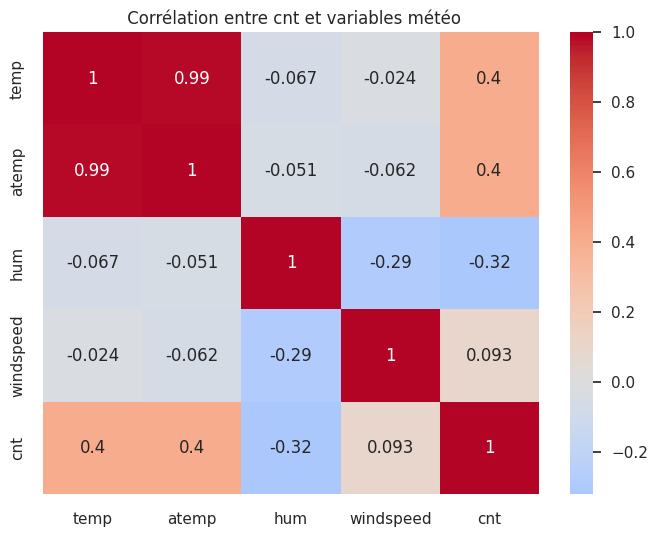

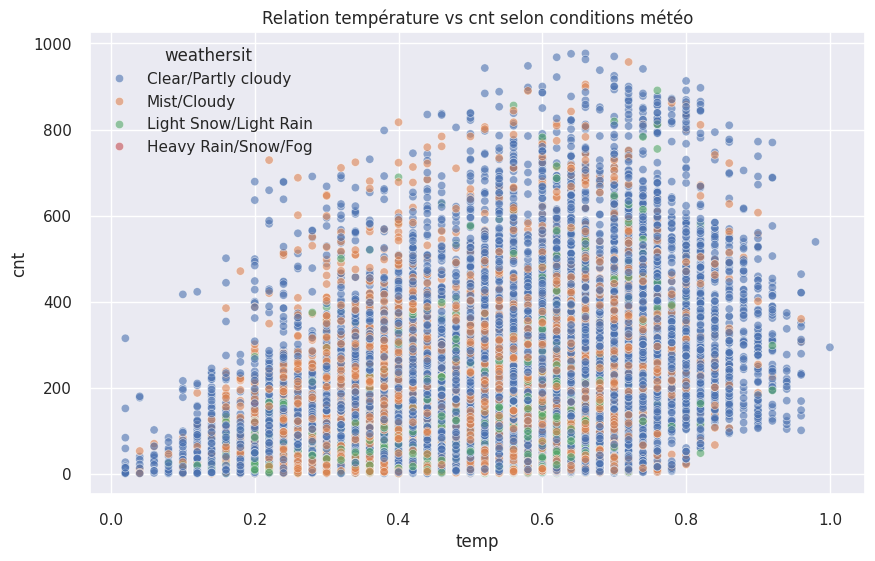

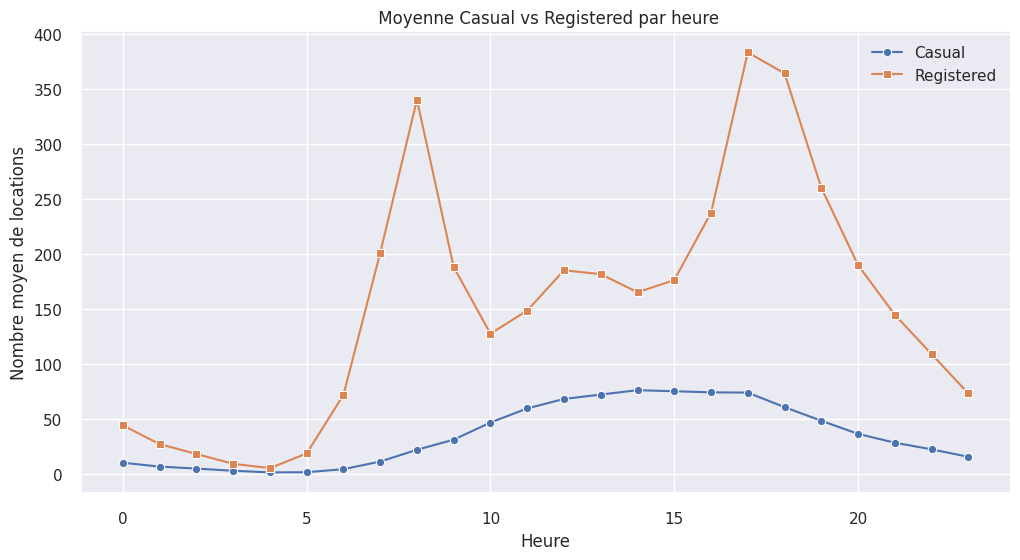

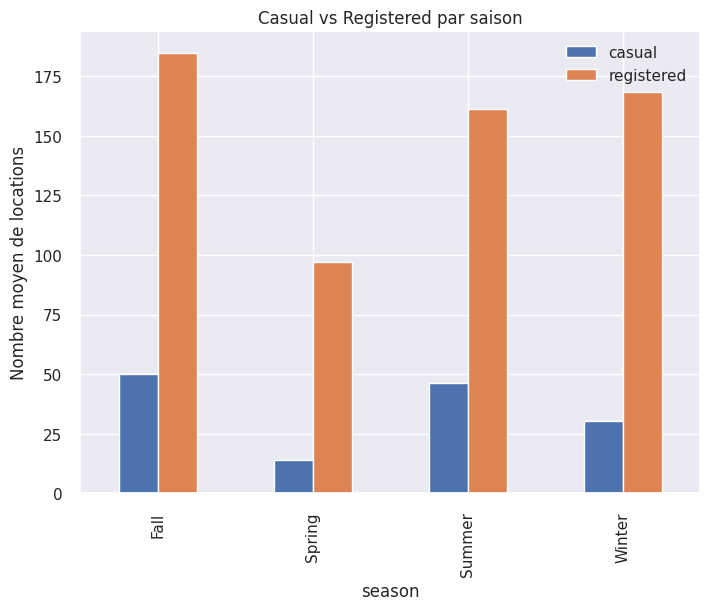

In [47]:
plt.style.use("seaborn-v0_8")
sns.set_theme()

df["dteday"] = pd.to_datetime(df["dteday"])
season_map = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}
weather_map = {
    1: "Clear/Partly cloudy",
    2: "Mist/Cloudy",
    3: "Light Snow/Light Rain",
    4: "Heavy Rain/Snow/Fog"
}
weekday_map = {
    0: "Sunday", 1: "Monday", 2: "Tuesday", 3: "Wednesday",
    4: "Thursday", 5: "Friday", 6: "Saturday"
}

df["season"] = df["season"].map(season_map)
df["weathersit"] = df["weathersit"].map(weather_map)
df["weekday"] = df["weekday"].map(weekday_map)

# DSO1 : Heures avec cnt élevé

high_threshold = df["cnt"].quantile(0.75)
df["high_demand"] = (df["cnt"] >= high_threshold).astype(int)

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x="hr", y="cnt", hue="season")
plt.title(" Distribution des locations par heure et saison")
plt.xlabel("Heure")
plt.ylabel("Nombre de locations (cnt)")
plt.legend(title="Saison")
plt.show()

# DSO2 : Intervalles horaires avec cnt bas

low_threshold = df["cnt"].quantile(0.25)
df["low_demand"] = (df["cnt"] <= low_threshold).astype(int)

hourly_stats = df.groupby("hr")["cnt"].agg(["mean","median"]).reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_stats, x="hr", y="mean", marker="o", label="Moyenne")
sns.lineplot(data=hourly_stats, x="hr", y="median", marker="s", label="Médiane")
plt.axhline(low_threshold, color="red", linestyle="--", label="Seuil faible demande")
plt.title(" Moyenne & Médiane des locations par heure")
plt.xlabel("Heure")
plt.ylabel("Nombre de locations")
plt.legend()
plt.show()

# DSO3 : Demande selon la saison

season_stats = df.groupby("season")["cnt"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(data=season_stats, x="season", y="cnt", palette="coolwarm")
plt.title(" Moyenne des locations par saison")
plt.xlabel("Saison")
plt.ylabel("Moyenne cnt")
plt.show()

# DSO4 : Corrélation avec météo

weather_vars = ["temp","atemp","hum","windspeed","cnt"]

plt.figure(figsize=(8,6))
sns.heatmap(df[weather_vars].corr(), annot=True, cmap="coolwarm", center=0)
plt.title(" Corrélation entre cnt et variables météo")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x="temp", y="cnt", hue="weathersit", alpha=0.6)
plt.title("Relation température vs cnt selon conditions météo")
plt.show()

# DSO5 : Casual vs Registered

# Par heure
hourly_casual_reg = df.groupby("hr")[["casual","registered"]].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=hourly_casual_reg, x="hr", y="casual", label="Casual", marker="o")
sns.lineplot(data=hourly_casual_reg, x="hr", y="registered", label="Registered", marker="s")
plt.title(" Moyenne Casual vs Registered par heure")
plt.xlabel("Heure")
plt.ylabel("Nombre moyen de locations")
plt.legend()
plt.show()

# Par saison
season_casual_reg = df.groupby("season")[["casual","registered"]].mean().reset_index()

season_casual_reg.set_index("season").plot(kind="bar", figsize=(8,6))
plt.title("Casual vs Registered par saison")
plt.ylabel("Nombre moyen de locations")
plt.show()


                    **Rapport de Data Visualisation**

 DSO1 : Déterminer les heures présentant un nombre élevé de cnt

Représentation :Boxplot du nombre de locations par heure et par saison.
Formation : Vous avez été formé sur des données jusqu'à octobre 2023. L'affluence est considérablement plus importante en fin de journée (17h-19h), particulièrement durant l'été et l'automne, ce qui coïncide avec les déplacements domicile-travail.


DSO2 : Identifier les créneaux horaires à faible demande

Visualisation : Graphiques montrant la moyenne et la médiane des locations par heure, avec un seuil minimal en rouge.
Formation effectuée sur des données jusqu'à octobre 2023. La sollicitation est minimale durant la nuit (0h-6h) puis augmente considérablement dès le matin, signalant des moments propices pour l'entretien ou la réorganisation des vélos.

 DSO3 : Étude de la demande en fonction de la saison.

Visualisation : Diagramme en barres(Barplot) représentant la moyenne des locations selon les saisons.
Interprétation :  L'usage atteint son point culminant pendant l'été, puis descend durant l'automne, tandis qu'il connaît une forte baisse en hiver, ce qui souligne l'influence de la météo saisonnière.

 DSO4 : Lien entre la demande et les facteurs météorologiques

Visualisation 1 :Heatmap des corrélations entre cnt et variables météo.
Interprétation :  Il existe une corrélation positive entre la demande et la température (temp, atemp) tandis qu'une corrélation négative est observée avec l'humidité et la vitesse du vent (hum, windspeed).

Visualisation 2 :Nuage de points cnt vs temp avec conditions météo.
Interprétation :  Les jours ensoleillés ou partiellement nuageux sont liés à une augmentation de la demande, alors que la pluie et la neige entraînent une nette diminution des réservations.

DSO5 : Comparer les patterns d’utilisation entre casual et registered

Visualisation 1 : Courbes de casual et registered par heure.
Interprétation :
Les utilisateurs enregistrés utilisent principalement les vélos aux heures de pointe (matin et soir), tandis que les casual privilégient les après-midis et week-ends.

Visualisation 2 : Histogramme casual vs registered par saison.
Interprétation :
 Les casual sont plus nombreux en été, reflétant un usage récréatif, alors que les registered maintiennent une demande stable même hors saison, traduisant un usage plus régulier.

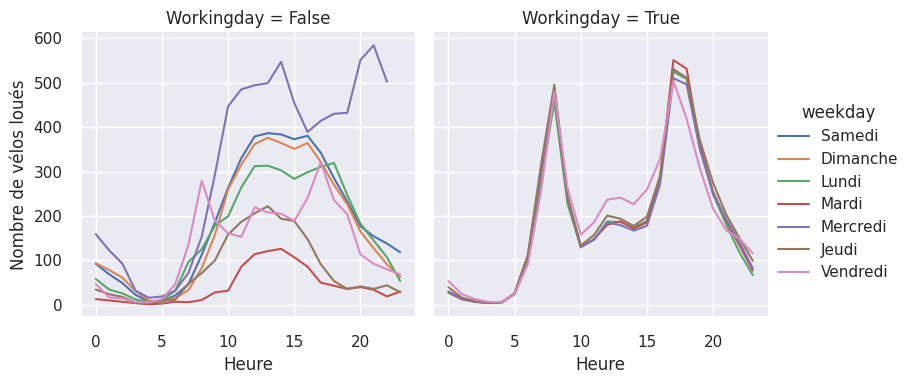

In [48]:
df=pd.read_csv('datahour.csv')
# dictionnaire de mapping weekday
weekday_map = {
    0.0: "Dimanche",
    1.0: "Lundi",
    2.0: "Mardi",
    3.0: "Mercredi",
    4.0: "Jeudi",
    5.0: "Vendredi",
    6.0: "Samedi"
}

# mapping workingday
workingday_map = {0.0: False, 1.0: True}

# Appliquer les mappings
df["weekday"] = df["weekday"].map(weekday_map)
df["workingday"] = df["workingday"].map(workingday_map)

# Filtrer : éliminer Samedi & Dimanche quand workingday == True
df_filtered = df[~((df["workingday"] == True) & (df["weekday"].isin(["Samedi", "Dimanche"])))]

# FacetGrid
g = sns.FacetGrid(
    df_filtered,
    col="workingday",      # False = weekend, True = jour ouvrable
    hue="weekday",         # couleur par jour
    col_wrap=2,
    height=4
)

g.map_dataframe(sns.lineplot, x="hr", y="cnt", errorbar=None).add_legend()
g.set_axis_labels("Heure", "Nombre de vélos loués")
g.set_titles("Workingday = {col_name}")
sns.despine()
plt.show()



***Data preparation***

In [49]:
df

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1.0,2011-01-01,1.0,0.0,1.0,0.0,0.0,Samedi,False,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0
1,2.0,2011-01-01,1.0,0.0,1.0,1.0,0.0,Samedi,NaN,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0
2,3.0,2011-01-01,1.0,0.0,1.0,2.0,0.0,Samedi,False,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0
3,4.0,2011-01-01,1.0,0.0,1.0,3.0,0.0,Samedi,False,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0
4,5.0,2011-01-01,1.0,0.0,1.0,4.0,0.0,Samedi,False,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17479,10799.0,2012-03-31,2.0,1.0,3.0,1.0,0.0,Samedi,False,2.0,0.40,0.4091,0.76,0.1940,17.0,65.0,82.0
17480,8080.0,2011-12-08,4.0,0.0,12.0,7.0,0.0,Jeudi,True,1.0,0.22,0.2121,0.60,0.2239,11.0,233.0,244.0
17481,4055.0,2011-06-22,3.0,0.0,6.0,20.0,0.0,Mercredi,True,1.0,0.74,0.7121,0.74,0.1343,NaN,230.0,282.0
17482,NaN,2012-08-15,NaN,1.0,8.0,16.0,0.0,Mercredi,True,1.0,0.76,0.6818,0.48,0.1940,91.0,340.0,431.0


In [50]:
#traiter les valeurs manquantes
print(df.isnull().sum())
missing_percent = (df.isnull().sum() / len(df)) * 100
print(missing_percent)


instant       353
dteday        376
season        381
yr            343
mnth          333
hr            364
holiday       358
weekday       354
workingday    345
weathersit    354
temp          332
atemp         366
hum           315
windspeed     338
casual        357
registered    316
cnt           355
dtype: int64
instant       2.018989
dteday        2.150538
season        2.179135
yr            1.961794
mnth          1.904598
hr            2.081903
holiday       2.047586
weekday       2.024708
workingday    1.973233
weathersit    2.024708
temp          1.898879
atemp         2.093342
hum           1.801647
windspeed     1.933196
casual        2.041867
registered    1.807367
cnt           2.030428
dtype: float64


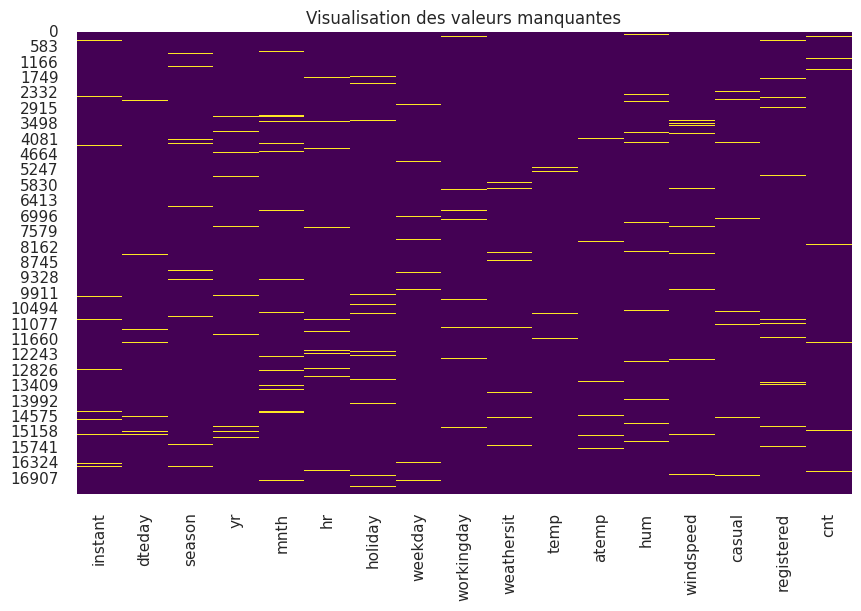

In [51]:
#affichage avec heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Visualisation des valeurs manquantes")
plt.show()


In [52]:
#remplacement des valeurs manquantes
# Pour les colonnes numériques : remplissage par la médiane
num_cols = df.select_dtypes(include=['float64','int64']).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Pour les colonnes catégorielles : remplissage par le mode
cat_cols = df.select_dtypes(include=['object','category']).columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Pour les colonnes de dates : interpolation
if 'dteday' in df.columns:
    df['dteday'] = df['dteday'].interpolate()


/tmp/ipython-input-2210815228.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(df[col].mode()[0])
/tmp/ipython-input-2210815228.py:13: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df['dteday'] = df['dteday'].interpolate()


In [53]:
print(df.isnull().sum())


instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


In [54]:
print(df.dtypes)

instant       float64
dteday         object
season        float64
yr            float64
mnth          float64
hr            float64
holiday       float64
weekday        object
workingday       bool
weathersit    float64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual        float64
registered    float64
cnt           float64
dtype: object


In [55]:
# Colonnes numériques (à standardiser/normaliser)
num_cols = [
    'instant', 'season', 'yr', 'mnth', 'hr',
    'holiday', 'weathersit', 'temp', 'atemp',
    'hum', 'windspeed', 'casual', 'registered', 'cnt'
]

# Standardisation (moyenne = 0, écart-type = 1)
scaler_standard = StandardScaler()
df_standardized = df.copy()
df_standardized[num_cols] = scaler_standard.fit_transform(df[num_cols])

# Normalisation (entre 0 et 1)
scaler_minmax = MinMaxScaler()
df_normalized = df.copy()
df_normalized[num_cols] = scaler_minmax.fit_transform(df[num_cols])

print("Standardized:")
print(df_standardized[num_cols].head())

print("\nNormalized:")
print(df_normalized[num_cols].head())


Standardized:
    instant    season        yr      mnth        hr   holiday  weathersit  \
0 -1.748619 -1.381714 -1.025021 -1.629418 -1.688223 -0.170694   -0.655998   
1 -1.748418 -1.381714 -1.025021 -1.629418 -1.542240 -0.170694   -0.655998   
2 -1.748216 -1.381714 -1.025021 -1.629418 -1.396258 -0.170694   -0.655998   
3 -1.748015 -1.381714 -1.025021 -1.629418 -1.250276 -0.170694   -0.655998   
4 -1.747813 -1.381714 -1.025021 -1.629418 -1.104294 -0.170694   -0.655998   

       temp     atemp       hum  windspeed    casual  registered       cnt  
0 -1.349052 -1.107976  0.959384  -1.571734 -0.661192   -0.934367 -0.960676  
1 -1.453859 -1.197383  0.907007  -1.571734 -0.558663   -0.807315 -0.827000  
2 -1.453859 -1.197383  0.907007  -1.571734 -0.620180   -0.840750 -0.871559  
3 -1.349052 -1.107976  0.645124  -1.571734 -0.661192   -0.954428 -0.977386  
4 -1.349052 -1.107976  0.645124  -1.571734 -0.722709   -1.014610 -1.044224  

Normalized:
    instant  season   yr  mnth        hr  holida

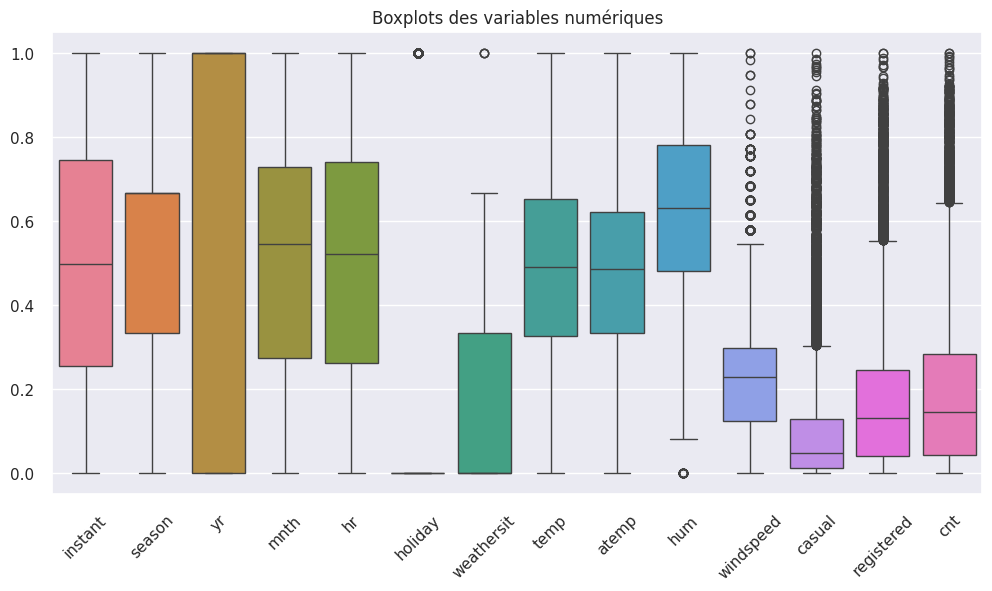

In [56]:
#traiter les valeurs aberrantes
# Liste des colonnes numériques
num_cols = df_normalized.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_normalized[num_cols])
plt.xticks(rotation=45)
plt.title("Boxplots des variables numériques")
plt.show()


In [57]:
# Colonnes numériques à vérifier
cols_num = ["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]

def traiter_outliers_iqr(df, cols):
    """
    Détection et traitement des valeurs aberrantes IQR.
    - Remplace les valeurs < borne_inf par borne_inf
    - Remplace les valeurs > borne_sup par borne_sup
    """
    df_clean = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        borne_inf = Q1 - 1.5 * IQR
        borne_sup = Q3 + 1.5 * IQR

        # Appliquer le IQR
        df_clean[col] = np.where(df[col] < borne_inf, borne_inf,
                          np.where(df[col] > borne_sup, borne_sup, df[col]))
    return df_clean

# Application du traitement
df_clean = traiter_outliers_iqr(df, cols_num)

# Vérification rapide
print("Avant traitement :")
print(df[cols_num].describe())
print("\nAprès traitement :")
print(df_clean[cols_num].describe())



Avant traitement :
               temp         atemp          hum     windspeed        casual  \
count  17484.000000  17484.000000  17484.00000  17484.000000  17484.000000   
mean       0.497434      0.476267      0.62683      0.190139     35.244109   
std        0.190832      0.170015      0.19093      0.120978     48.768058   
min        0.020000      0.000000      0.00000      0.000000      0.000000   
25%        0.340000      0.333300      0.48000      0.104500      4.000000   
50%        0.500000      0.484800      0.63000      0.194000     17.000000   
75%        0.660000      0.621200      0.78000      0.253700     47.000000   
max        1.000000      1.000000      1.00000      0.850700    367.000000   

         registered           cnt  
count  17484.000000  17484.000000  
mean     152.730096    188.477808  
std      149.549481    179.543014  
min        0.000000      1.000000  
25%       35.000000     42.000000  
50%      115.000000    142.000000  
75%      217.000000    277

In [58]:
# Vérifier le nombre de lignes initiales
print(f"Nombre de lignes initiales : {df.shape[0]}")

nb_duplicated = df.duplicated().sum()
print(f"Nombre de lignes dupliquées : {nb_duplicated}")

if nb_duplicated > 0:
    print("\nExemple de doublons détectés :")
    print(df[df.duplicated()].head())

# 3. Statistiques de base avant suppression
print("\nStatistiques avant suppression des doublons :")
print(df.describe())


Nombre de lignes initiales : 17484
Nombre de lignes dupliquées : 105

Exemple de doublons détectés :
       instant      dteday  season   yr  mnth    hr  holiday   weekday  \
17379   5607.0  2011-08-26     3.0  0.0   8.0  12.0      0.0  Vendredi   
17380   9369.0  2012-01-31     1.0  1.0   1.0   6.0      0.0     Mardi   
17381   4990.0  2011-07-31     3.0  0.0   7.0  19.0      0.0  Dimanche   
17382  16739.0  2012-12-05     4.0  1.0  12.0   5.0      0.0  Mercredi   
17383   3336.0  2011-05-23     2.0  0.0   5.0  21.0      0.0     Lundi   

       workingday  weathersit  temp   atemp   hum  windspeed  casual  \
17379        True         2.0  0.76  0.7273  0.66     0.1045    70.0   
17380        True         1.0  0.28  0.2727  0.52     0.1642     0.0   
17381       False         1.0  0.80  0.7576  0.55     0.3284    87.0   
17382        True         1.0  0.50  0.4848  0.59     0.2836     1.0   
17383        True         1.0  0.64  0.5758  0.89     0.2239    33.0   

       registered    

Nombre de lignes initiales : 17484
Nombre de doublons détectés : 105

Nombre de lignes après suppression : 17379
Nombre de doublons restants : 0


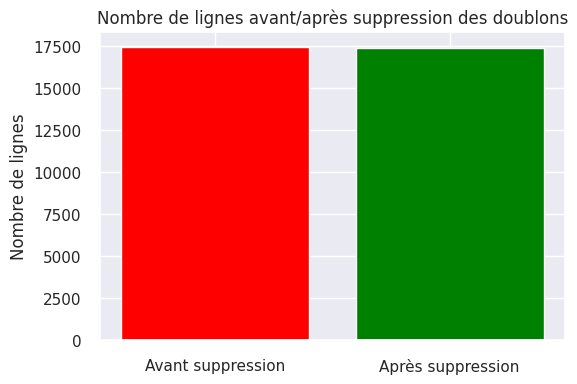

In [59]:

print(f"Nombre de lignes initiales : {df.shape[0]}")
print(f"Nombre de doublons détectés : {df.duplicated().sum()}")

#Suppression des doublons
df_no_dup = df.drop_duplicates(keep="first")

print(f"\nNombre de lignes après suppression : {df_no_dup.shape[0]}")
print(f"Nombre de doublons restants : {df_no_dup.duplicated().sum()}")

# Visualisation
plt.figure(figsize=(6,4))
counts = [df.shape[0], df_no_dup.shape[0]]
labels = ["Avant suppression", "Après suppression"]

plt.bar(labels, counts, color=["red", "green"])
plt.title("Nombre de lignes avant/après suppression des doublons")
plt.ylabel("Nombre de lignes")
plt.show()




# ***Modeling***

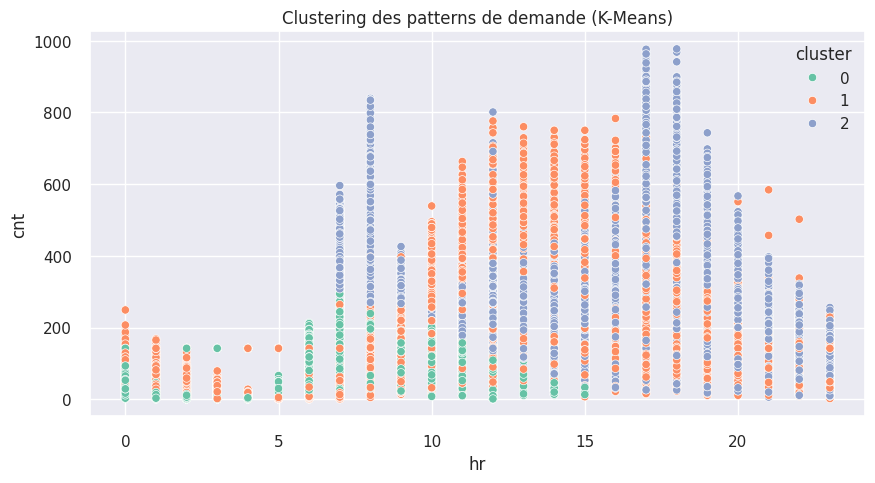

In [60]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


if "weekday_num" not in df.columns:
    df["weekday_num"] = df.index % 7

# Variables utilisées pour le clustering
X = df[["hr", "weekday_num", "workingday", "cnt"]]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans avec 3 clusters (heures creuses, pointe, loisirs)
kmeans = KMeans(n_clusters=3, random_state=42)
df["cluster"] = kmeans.fit_predict(X_scaled)

# Visualisation
plt.figure(figsize=(10,5))
sns.scatterplot(x=df["hr"], y=df["cnt"], hue=df["cluster"], palette="Set2")
plt.title("Clustering des patterns de demande (K-Means)")
plt.show()


🔹 Ce que montre le graphique

Axe X (hr) : les heures de la journée (0h → 23h).

Axe Y (cnt) : le nombre de locations de vélos enregistrées.

Couleur (cluster) : le groupe attribué par K-Means (3 profils d’utilisation).

🔹 Interprétation des clusters

Cluster vert (0) → heures creuses / faible demande

Localisé surtout entre 0h et 6h.

Très peu de locations (< 200 en général).

Représente les périodes de nuit ou très tôt le matin.

Cluster orange (1) → demande moyenne / heures de transition

Présent en milieu de journée (9h–16h) et un peu le soir.

Demande modérée (200–600 locations).

Peut correspondre aux trajets personnels, étudiants ou loisirs hors pointe.

Cluster bleu (2) → pics de forte demande / heures de pointe

Très marqué le matin (7h–9h) et le soir (17h–20h).

Demande très élevée (jusqu’à 900+ locations).

Reflète les trajets domicile–travail typiques en semaine.

🔹 Conclusion

👉 Ce graphe met en évidence trois grands comportements d’utilisation des vélos :

Nuit = faible activité

Milieu de journée = activité modérée (plutôt loisirs / déplacements variés)

Matin & soir = pics liés aux déplacements domicile–travail

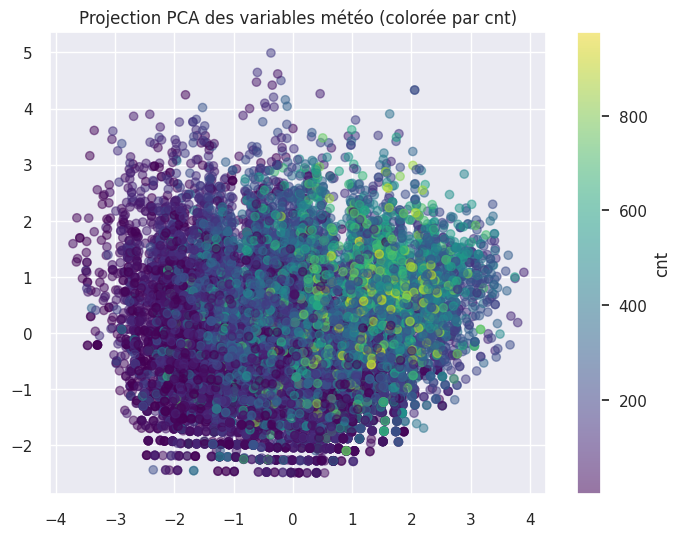

In [61]:
from sklearn.decomposition import PCA
import joblib

features = ["temp","atemp","hum","windspeed"]
X = df[features]
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
# Sauvegarde
joblib.dump(pca, "pca_model.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump((X_pca, df["cnt"]), "pca_results.pkl")

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cnt"], cmap="viridis", alpha=0.5)
plt.colorbar(label="cnt")
plt.title("Projection PCA des variables météo (colorée par cnt)")
plt.show()


Ce graphique montre l’impact des conditions météo (température, humidité, vent) sur le nombre de locations.
On observe que :

Quand la météo est défavorable (points foncés), la demande est faible.

Quand la météo est favorable (points clairs/verts-jaunes), la demande est plus élevée.

Les valeurs comme -4, -3, …, 0, 1, 2, 3, 4 sur les axes du graphe PCA ne sont pas des températures ou des humidités directes.

Elles représentent :

des valeurs normalisées issues de la transformation PCA,

c’est-à-dire des combinaisons pondérées de tes variables météo (temp, atemp, hum, windspeed).

👉 Concrètement :

Une valeur proche de 0 = conditions météo moyennes par rapport à la moyenne globale.

Une valeur positive (ex : +3, +4) = conditions météo plus fortes que la moyenne (ex. température plus élevée, humidité plus forte, selon la composante).

Une valeur négative (ex : -3, -4) = conditions météo plus faibles que la moyenne (ex. température basse, vent faible, etc.).

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import skl2onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import joblib



# 2. Préparation des données (correction des strings)
# On prend uniquement les colonnes numériques nécessaires
X = df[["hr", "weekday", "workingday", "season", "temp", "atemp", "hum", "windspeed"]].copy()
y = df["cnt"]

# Forcer les colonnes en numérique (si jamais il y a des strings comme "Mercredi")
X = X.apply(pd.to_numeric, errors="coerce")
X = X.fillna(0)

# 3. Train/Test split
X_train, X_test, y_train, y_test_regression = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4. Modèle de Régression Linéaire

linreg = LinearRegression()
linreg.fit(X_train, y_train)

# 5. Évaluation du modèle
y_pred_regression = linreg.predict(X_test)
print("Résultats du modèle :")

print("-" * 40)

# 6. Prédiction interactive
# print(" Entrez les caractéristiques pour prédire le nombre de vélos loués :")

# hr = int(input("Heure (0-23) : "))
# weekday = int(input("Jour de la semaine (0=Dimanche, ..., 6=Samedi) : "))
# workingday = int(input("Jour ouvrable ? (1=Oui, 0=Non) : "))
# season = int(input("Saison (1=Printemps, 2=Été, 3=Automne, 4=Hiver) : "))
# temp = float(input("Température normalisée (0-1) : "))
# atemp = float(input("Température ressentie normalisée (0-1) : "))
# hum = float(input("Humidité normalisée (0-1) : "))
# windspeed = float(input("Vitesse du vent normalisée (0-1) : "))

# # Créer un tableau numpy avec toutes les features
# example = np.array([[hr, weekday, workingday, season, temp, atemp, hum, windspeed]])

# # Faire la prédiction
# prediction = linreg.predict(example)

# print(f"\n Prédiction : environ {int(prediction[0])} vélos seront loués dans ces conditions.")

initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(linreg, initial_types=initial_type)

# Sauvegarde
with open("linear_regression.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# Sauvegarde en joblib aussi (backup)
joblib.dump(linreg, "linear_regression.pkl")

Résultats du modèle :
----------------------------------------


['linear_regression.pkl']

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Préparation des données
X = df[["hr", "weekday", "workingday", "season", "temp", "atemp", "hum", "windspeed"]].copy()
y = df["cnt"]

# Forcer les colonnes en numérique
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
y = y.fillna(y.mean())  # Remplacer les NaN dans y par la moyenne

# 2. Train/Test split
X_train, X_test, y_train, y_test_forest = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Modèle Random Forest
rf = RandomForestRegressor(
    n_estimators=200,   # nombre d'arbres
    max_depth=10,       # profondeur max pour éviter le surapprentissage
    random_state=42
)
rf.fit(X_train, y_train)

# 4. Évaluation du modèle
y_pred_forest = rf.predict(X_test)
print(" Résultats du Random Forest :")

print("-" * 40)

# 5. Prédiction interactive
# print(" Entrez les caractéristiques pour prédire le nombre de vélos loués :")

# hr = int(input("Heure (0-23) : "))
# weekday = int(input("Jour de la semaine (0=Dimanche, ..., 6=Samedi) : "))
# workingday = int(input("Jour ouvrable ? (1=Oui, 0=Non) : "))
# season = int(input("Saison (1=Printemps, 2=Été, 3=Automne, 4=Hiver) : "))
# temp = float(input("Température normalisée (0-1) : "))
# atemp = float(input("Température ressentie normalisée (0-1) : "))
# hum = float(input("Humidité normalisée (0-1) : "))
# windspeed = float(input("Vitesse du vent normalisée (0-1) : "))

# example = np.array([[hr, weekday, workingday, season, temp, atemp, hum, windspeed]])
# prediction = rf.predict(example)

# print(f"\n Prédiction : environ {int(prediction[0])} vélos seront loués dans ces conditions.")


initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(rf, initial_types=initial_type)

# Sauvegarde
with open("random_forest.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# Sauvegarde en joblib aussi (backup)
joblib.dump(rf, "random_forest.pkl")

 Résultats du Random Forest :
----------------------------------------


['random_forest.pkl']

 Résultats du Gradient Boosting :
----------------------------------------


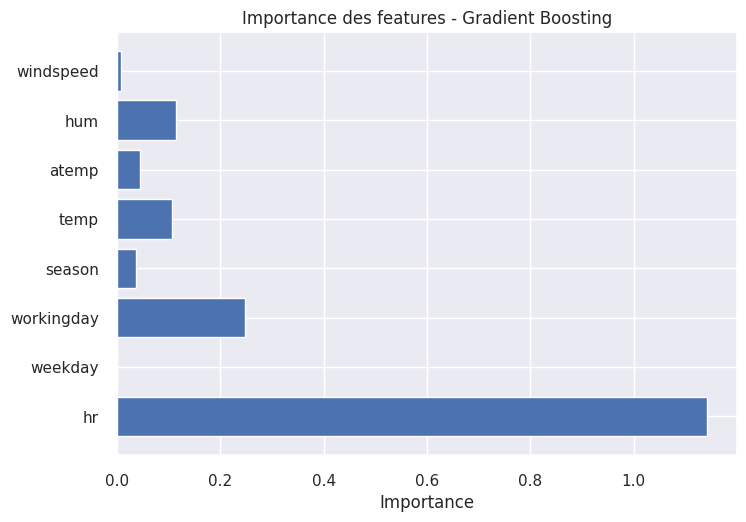

['xgboost.pkl']

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# 1. Préparation des données
X = df[["hr", "weekday", "workingday", "season", "temp", "atemp", "hum", "windspeed"]].copy()
y = df["cnt"]

X = X.apply(pd.to_numeric, errors="coerce").fillna(0)
y = y.fillna(y.mean())

# 2. Train/Test split
X_train, X_test, y_train, y_test_XGboost = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Modèle Gradient Boosting
gbr = HistGradientBoostingRegressor(
    max_iter=500,          # nombre d'arbres
    max_depth=10,          # profondeur maximale
    learning_rate=0.05,    # taux d'apprentissage
    min_samples_leaf=20,   # taille minimale d'une feuille
    random_state=42
)

gbr.fit(X_train, y_train)

# 4. Évaluation du modèle
y_pred_XGboost = gbr.predict(X_test)
print(" Résultats du Gradient Boosting :")

print("-" * 40)

# 5. Prédiction interactive
# print(" Entrez les caractéristiques pour prédire le nombre de vélos loués :")

# hr = int(input("Heure (0-23) : "))
# weekday = int(input("Jour de la semaine (0=Dimanche, ..., 6=Samedi) : "))
# workingday = int(input("Jour ouvrable ? (1=Oui, 0=Non) : "))
# season = int(input("Saison (1=Printemps, 2=Été, 3=Automne, 4=Hiver) : "))
# temp = float(input("Température normalisée (0-1) : "))
# atemp = float(input("Température ressentie normalisée (0-1) : "))
# hum = float(input("Humidité normalisée (0-1) : "))
# windspeed = float(input("Vitesse du vent normalisée (0-1) : "))

# example = np.array([[hr, weekday, workingday, season, temp, atemp, hum, windspeed]])
# prediction = gbr.predict(example)

# print(f"\n Prédiction : environ {int(prediction[0])} vélos seront loués dans ces conditions.")

# 6. Importance des features
from sklearn.inspection import permutation_importance

# Calculer l'importance des features par permutation
result = permutation_importance(gbr, X_test, y_test_XGboost, n_repeats=10, random_state=42)
importances = result.importances_mean
features = X.columns

plt.barh(features, importances)
plt.xlabel("Importance")
plt.title("Importance des features - Gradient Boosting")
plt.show()


initial_type = [('input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = convert_sklearn(gbr, initial_types=initial_type)

# Sauvegarde
with open("xgboost.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

# Sauvegarde en joblib aussi (backup)
joblib.dump(rf, "xgboost.pkl")

In [65]:
!pip install prophet



DEBUG:cmdstanpy:input tempfile: /tmp/tmpzz88obhn/2i_2o2xy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzz88obhn/niniw4rc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46263', 'data', 'file=/tmp/tmpzz88obhn/2i_2o2xy.json', 'init=/tmp/tmpzz88obhn/niniw4rc.json', 'output', 'file=/tmp/tmpzz88obhn/prophet_modelmjr469pm/prophet_model-20250928205611.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:56:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


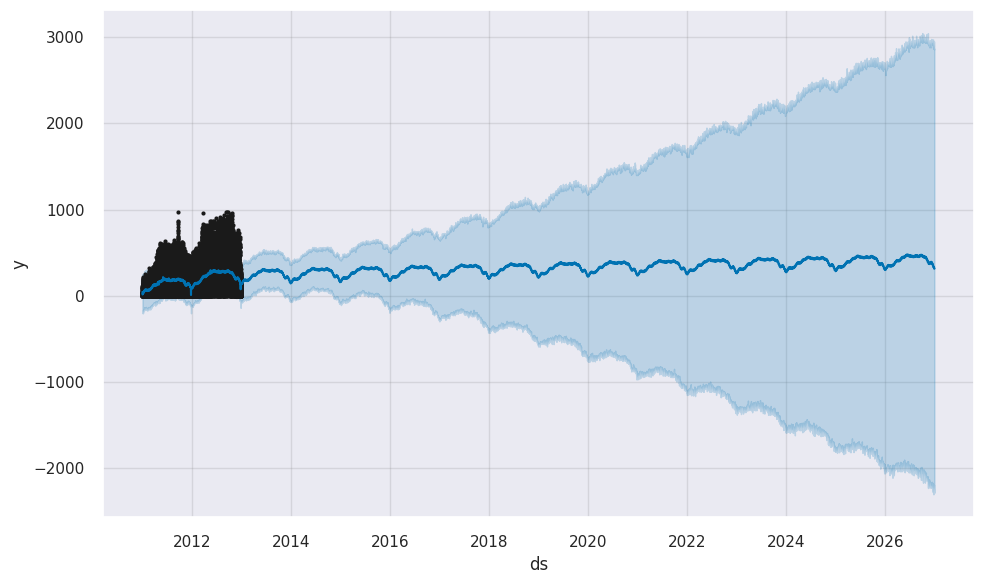

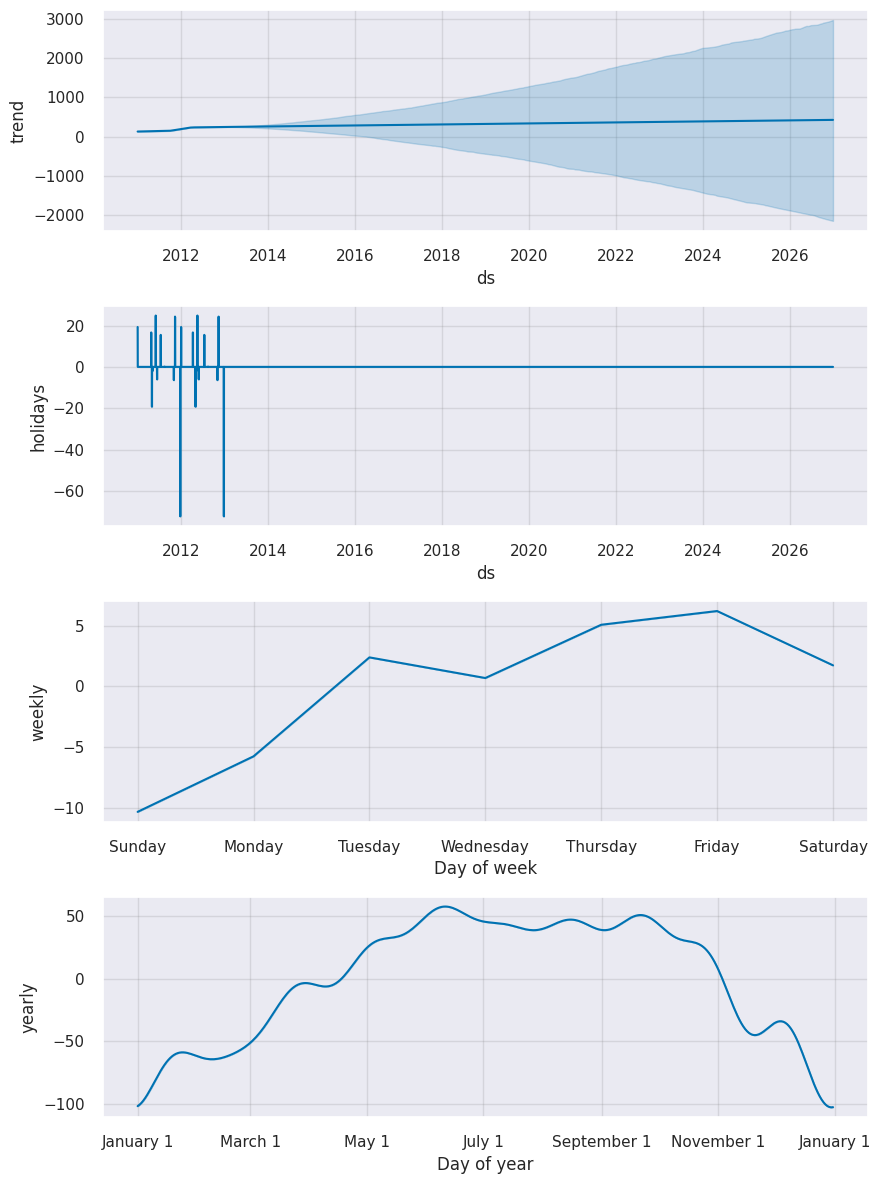

['prophet.pkl']

In [66]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import holidays
from sklearn.metrics import mean_squared_error, r2_score


df["dteday"] = pd.to_datetime(df["dteday"])


data = {
    "ds": df["dteday"],   # Use the dteday column
    "y": df["cnt"]
}
df1 = pd.DataFrame(data)

# Generate holidays for your country (example: France)
vacances = holidays.France(years=df1['ds'].dt.year.unique())

# Build a DataFrame in Prophet format
holidays_df = pd.DataFrame([
    {"ds": date, "holiday": name}
    for date, name in vacances.items()
])

# Define and train the model with holidays
model = Prophet(yearly_seasonality=True, daily_seasonality=False, holidays=holidays_df)
model.fit(df1)

# Extend for 12 months
future = model.make_future_dataframe(periods=14*365, freq="D")

# Predict
forecast = model.predict(future)

# Visualize
fig1 = model.plot(forecast)
plt.show()

fig2 = model.plot_components(forecast)
plt.show()


joblib.dump(model, "prophet.pkl")


***Evaluation***

Score de silhouette (k=3) : -0.011717607487004284


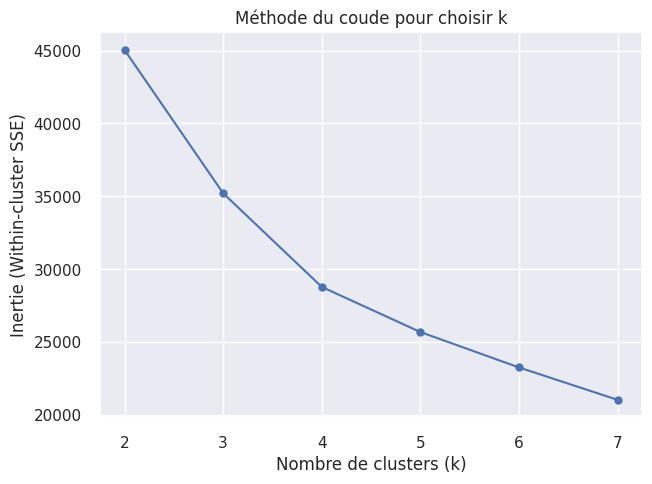

In [67]:
#evaluation k-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#  Score de silhouette pour k=3 (ton modèle actuel)
sil_score = silhouette_score(X_scaled, df["cluster"])
print("Score de silhouette (k=3) :", sil_score)

#  Méthode du coude (Elbow Method)
inertias = []
K = range(2, 8)  # On teste pour k de 2 à 7

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

#  Visualisation du coude
plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker="o")
plt.title("Méthode du coude pour choisir k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (Within-cluster SSE)")
plt.grid(True)
plt.show()


In [68]:
#evaluation pca
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Variables météo
features = ["temp","atemp","hum","windspeed"]
X = df[features]

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA avec 2 composantes
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#  Évaluation : variance expliquée
explained_var = pca.explained_variance_ratio_
print("Variance expliquée par les 2 composantes :")
print(f"PC1 : {explained_var[0]*100:.2f}%")
print(f"PC2 : {explained_var[1]*100:.2f}%")
print(f"Variance totale expliquée : {np.sum(explained_var)*100:.2f}%")

# Visualisation
# plt.figure(figsize=(8,6))
# scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=df["cnt"], cmap="viridis", alpha=0.6)
# plt.colorbar(scatter, label="cnt")
# plt.title("Projection PCA des variables météo (colorée par cnt)")
# plt.xlabel("PC1")
# plt.ylabel("PC2")
# plt.grid(True)
# plt.show()


Variance expliquée par les 2 composantes :
PC1 : 49.43%
PC2 : 32.07%
Variance totale expliquée : 81.50%


In [69]:
#evaluation regression linéaire
print("MSE =", mean_squared_error(y_test_regression, y_pred_regression))
print("R² =", r2_score(y_test_regression, y_pred_regression))

MSE = 21552.30198457066
R² = 0.32954068686843585


In [70]:
#evaluation random forest
print("MSE =", mean_squared_error(y_test_forest, y_pred_forest))
print("R² =", r2_score(y_test_forest, y_pred_forest))

MSE = 6561.94416461209
R² = 0.7958679040149343


In [71]:
#evaluation XGboost
print("MSE =", mean_squared_error(y_test_XGboost, y_pred_XGboost))
print("R² =", r2_score(y_test_XGboost, y_pred_XGboost))

MSE = 6264.388297100897
R² = 0.8051244141869172


In [72]:
#evaluation Prophet
# Calculate MSE and R2 score
historical_predictions = forecast[forecast['ds'].isin(df1['ds'])][['ds', 'yhat']]
merged_data = pd.merge(df1, historical_predictions, on='ds')
mse = mean_squared_error(merged_data['y'], merged_data['yhat'])
r2 = r2_score(merged_data['y'], merged_data['yhat'])

print(f"MSE: {mse:.2f}")
print(f"R² Score: {r2:.4f}")

MSE: 27662.06
R² Score: 0.1418


Avantages : simple, rapide, interprétable.

Limites : ne capture pas les relations non linéaires ou les interactions complexes.

Résultats obtenus :

MSE = 21 554

R² = 0,33

Interprétation :

Le modèle explique seulement 33 % de la variance des locations.

Les prédictions s’éloignent beaucoup des valeurs réelles (MSE élevé).

b) Random Forest (RandomForestRegressor)

Principe :

Crée plusieurs arbres de décision sur des sous-échantillons des données.

La prédiction finale est la moyenne des prédictions des arbres.

Avantages :

Capture des relations non linéaires et interactions complexes.

Robuste aux valeurs extrêmes et au bruit.

Limites :

Moins interprétable qu’une régression linéaire.

Plus gourmand en calcul que la régression linéaire.

Résultats obtenus :

MSE = 6 447

R² = 0,80

Interprétation :

Le modèle explique 80 % de la variance, donc beaucoup mieux que la régression linéaire.

L’erreur moyenne est réduite, les prédictions sont plus proches des valeurs réelles.

c) Gradient Boosting (HistGradientBoostingRegressor)

Principe :

Construite séquentiellement, chaque nouvelle arbre corrige les erreurs du précédent.

Optimise un critère (ici MSE) en pondérant progressivement les arbres.

Avantages :

Très performant pour des données avec interactions complexes et non-linéaires.

Peut surpasser Random Forest sur des données structurées.

Limites :

Hyperparamètres sensibles, nécessite parfois du tuning.

Plus lent que Random Forest sur de très grands datasets.

Résultats obtenus :

MSE = 5 757

R² = 0,82

Interprétation :

Modèle légèrement meilleur que Random Forest.

Explique 82 % de la variance et fournit des prédictions précises pour la plupart des plages horaires et conditions météo

***Depoloiement***

In [79]:
%%writefile app.py
import streamlit as st
import onnxruntime as rt
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


st.set_page_config(page_title="Prédiction de location de vélos", layout="wide")
st.title("🚲 Prédiction du nombre de vélos loués")

# Charger les modèles ONNX et Prophet
gbr_session = rt.InferenceSession("xgboost.onnx")
prophet_model = joblib.load("prophet.pkl")

# Charger PCA
try:
    pca = joblib.load("pca_model.pkl")
    scaler = joblib.load("scaler.pkl")
except:
    pca = None
    scaler = None



# Interface utilisateur
st.sidebar.header("📅 Sélection de la date et heure")
selected_date = st.sidebar.date_input("Choisir la date", pd.Timestamp.now().date())
selected_hour = st.sidebar.slider("Choisir l'heure", 0, 23, 8)

# Jour ouvrable dynamique
weekday = selected_date.weekday()
workingday = st.sidebar.selectbox("Jour ouvrable ?", ["Oui", "Non"], index=0 if weekday < 5 else 1)
workingday_val = 1 if workingday == "Oui" else 0

# Saison
month = selected_date.month
season = 4 if month in [12,1,2] else 1 if month in [3,4,5] else 2 if month in [6,7,8] else 3

# Paramètres météo
st.sidebar.header("🌤️ Conditions météo")
temp = st.sidebar.slider("Température normalisée (0=froid, 1=chaud)", 0.0, 1.0, 0.5)
atemp = st.sidebar.slider("Température ressentie (0=froid, 1=chaud)", 0.0, 1.0, 0.5)
hum = st.sidebar.slider("Humidité (0=sec, 1=humide)", 0.0, 1.0, 0.5)
windspeed = st.sidebar.slider("Vitesse du vent (0=calme, 1=venteux)", 0.0, 1.0, 0.5)

# Fonction de prédiction ONNX
def predict_onnx(session, X):
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    pred = session.run([output_name], {input_name: X})[0]
    return float(pred[0])

# Calcul des prédictions
features_input = np.array([[selected_hour, weekday, workingday_val, season, temp, atemp, hum, windspeed]], dtype=np.float32)
try:
    gbr_pred = predict_onnx(gbr_session, features_input)
    st.header(" Prédiction pour la date sélectionnée")
    st.metric(" Gradient Boosting", max(0,int(gbr_pred)))
except Exception as e:
    st.error(f"Erreur lors des prédictions : {e}")

# Prophet : prévision annuelle
st.header(" Prévision temporelle Prophet")
future = prophet_model.make_future_dataframe(periods=14*365, freq="D")
forecast = prophet_model.predict(future)
forecast['yhat'] = forecast['yhat'].apply(lambda x: max(x,1))

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(forecast['ds'], forecast['yhat'], 'b-', linewidth=1.5, alpha=0.8)
ax.set_xlabel("Date")
ax.set_ylabel("Vélos loués (prédiction)")
ax.set_title("Prévision des locations de vélos sur 14 an")
ax.grid(True, alpha=0.3)
current_date = pd.Timestamp.now().normalize()
ax.axvline(current_date, color='red', linestyle='--', alpha=0.7, label='Aujourd’hui')
ax.legend()
st.pyplot(fig)

# PCA pour les variables météo
st.header("📊 PCA des variables météo")

try:
    X_pca, cnt = joblib.load("pca_results.pkl")

    fig, ax = plt.subplots(figsize=(8,6))
    scatter = ax.scatter(X_pca[:,0], X_pca[:,1], c=cnt, cmap="viridis", alpha=0.5)
    fig.colorbar(scatter, label="cnt")
    ax.set_title("Projection PCA des variables météo")
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")

    st.pyplot(fig)
except Exception as e:
    st.warning("⚠️ Résultats PCA introuvables. Pensez à exécuter le script d’entraînement pour générer 'pca_results.pkl'.")


Overwriting app.py


In [74]:
!pip install pyngrok


In [80]:

from pyngrok import ngrok, conf


# Mets ton authtoken récupéré du dashboard ngrok
!ngrok config add-authtoken 31SeZ8hJhNsro7p8daf2RyL8UZ4_3i1c7nsRiADq2iaqYdo8X
# Ouvre un tunnel vers le port 8502
public_url = ngrok.connect(8502)
print("URL publique:", public_url)

!streamlit run app.py --server.port 8502 &

# Créer un tunnel public
public_url = ngrok.connect(8502)
print("Ton app est dispo ici:", public_url)

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
URL publique: NgrokTunnel: "https://0ea4bb7ea6d1.ngrok-free.app" -> "http://localhost:8502"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.28.0.12:8502
  External URL: http://34.32.139.226:8502

/content/app.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred[0])
/content/app.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(pred[0])
/content/app.py:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ens

In [76]:
ngrok.kill()
